# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,classification_report
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import train_test_split, GridSearchCV


In [2]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [3]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



No columns have missing (NaN) values — all 21 features are complete.

2. Data Types Overview
Type	Columns	Notes
Numeric (int64, float64)	age, duration, campaign, pdays, previous, emp.var.rate, cons.price.idx, cons.conf.idx, euribor3m, nr.employed	All are correctly numeric.
Categorical (object)	job, marital, education, default, housing, loan, contact, month, day_of_week, poutcome, y	These should be encoded before modeling.


3. Values Needing Special Treatment

unknown appears frequently in columns such as job, education, default, housing, and loan.
→ These should either be treated as a separate category or replaced based on context.

pdays = 999 is a special code meaning the client was not previously contacted — it should be converted or handled as a separate flag.

duration — this variable should not be used in predictive modeling, since it’s only known after a call. You can keep it for benchmarking but exclude it for a realistic model.

4. Next Steps

We’ll:

Handle categorical encoding (e.g., one-hot or label encoding).

Handle special codes like pdays = 999.

Drop duration for realistic prediction modeling.

Would you like me to show the data cleaning and encoding code next (to prepare it for Logistic Regression, KNN, Decision Tree, and SVM)?

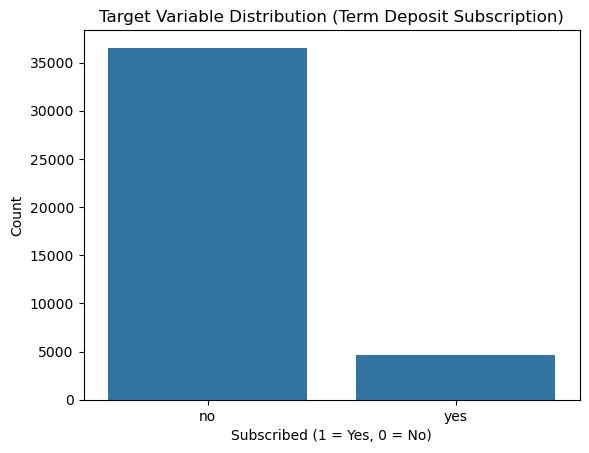

y
no     0.887346
yes    0.112654
Name: proportion, dtype: float64


In [4]:
sns.countplot(x='y', data=df)
plt.title('Target Variable Distribution (Term Deposit Subscription)')
plt.xlabel('Subscribed (1 = Yes, 0 = No)')
plt.ylabel('Count')
plt.show()

print(df['y'].value_counts(normalize=True))

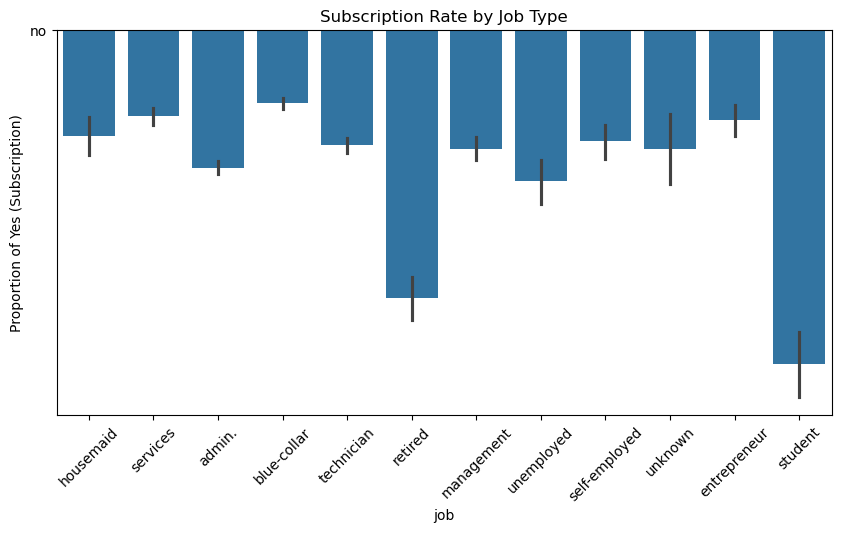

In [6]:
plt.figure(figsize=(10,5))
sns.barplot(x='job', y='y', data=df, estimator=lambda x: sum(x)/len(x))
plt.xticks(rotation=45)
plt.title('Subscription Rate by Job Type')
plt.ylabel('Proportion of Yes (Subscription)')
plt.show()

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Business Objective

The primary business objective is to improve the effectiveness and efficiency of the bank’s telemarketing campaigns for promoting long-term deposit subscriptions.

Specifically, the goal is to:

Develop predictive models that can identify which clients are most likely to subscribe to a term deposit when contacted.

By achieving this, the bank can:

Increase campaign success rates by targeting clients with higher likelihood of subscription.

Reduce marketing costs and minimize unnecessary calls to uninterested clients.

Optimize the use of resources such as time, staff, and phone outreach efforts.

Support data-driven decision making for future campaign planning and customer segmentation.

In technical terms, this becomes a binary classification task, where the model predicts:

y = 1 → client subscribes to a term deposit (“yes”)

y = 0 → client does not subscribe (“no”)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

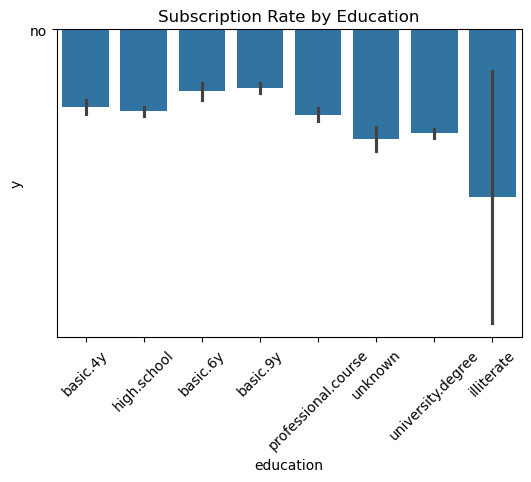

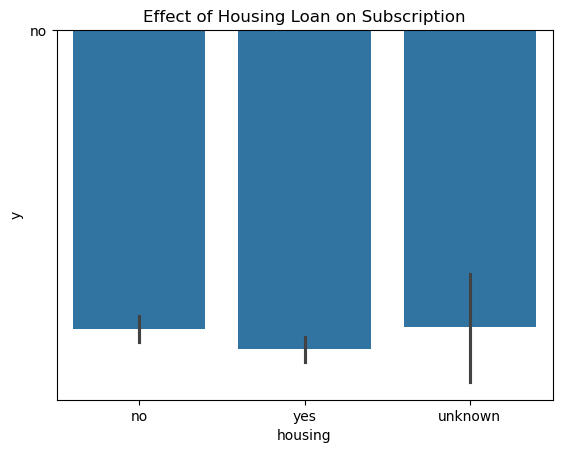

In [7]:
plt.figure(figsize=(6,4))
sns.barplot(x='education', y='y', data=df, estimator=lambda x: sum(x)/len(x))
plt.xticks(rotation=45)
plt.title('Subscription Rate by Education')
plt.show()

sns.barplot(x='housing', y='y', data=df)
plt.title('Effect of Housing Loan on Subscription')
plt.show()

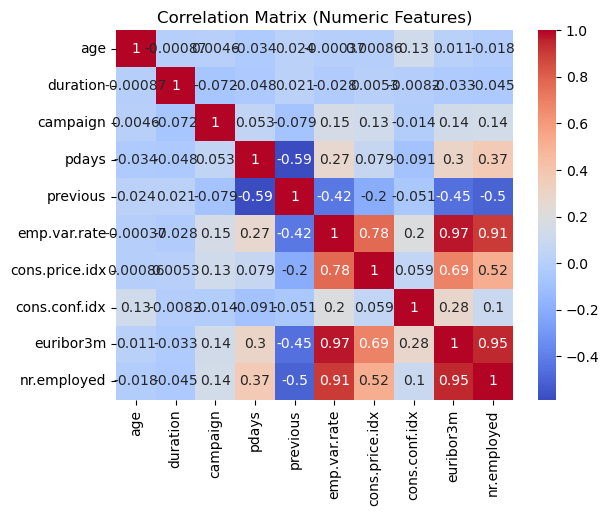

In [8]:
corr = df.select_dtypes(['number']).corr()
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix (Numeric Features)')
plt.show()

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

In [9]:
# -------------------------------
# 2. Prepare features and target
# -------------------------------

# Target variable: 'y' → yes/no (binary)
y_map={'yes': 1, 'no': 0}
df['y'] = df['y'].map(lambda x: y_map.get(str(x).lower(),np.nan) if pd.notna(x) else np.nan)
#df.dropna(subset=['y'])
#Separate features (X) and target (y)
X = df.drop('y', axis=1)
y = df['y']
# We can probably label encode education.
#Encode categorical variables
X = pd.get_dummies(X, drop_first=True)
X.head()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,...,month_may,month_nov,month_oct,month_sep,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_nonexistent,poutcome_success
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,True,False,False,False,True,False,False,False,True,False
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,True,False,False,False,True,False,False,False,True,False
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,True,False,False,False,True,False,False,False,True,False
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,True,False,False,False,True,False,False,False,True,False
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,...,True,False,False,False,True,False,False,False,True,False


### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)


### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In a binary classification task (like predicting if a client subscribes to a term deposit), the simplest baseline is usually:

Always predict the majority class (the most frequent outcome).
For our dataset (y = yes/no), we can compute:

In [11]:
# Compute baseline accuracy: always predict majority class
# 1️⃣ Determine the majority class
majority_class = y_train.mode()[0]

# 2️⃣ Predict that class for all test samples
y_pred_baseline = [majority_class] * len(y_test)

# 3️⃣ Evaluate
baseline_acc = accuracy_score(y_test, y_pred_baseline)

print("Baseline Model (No Algorithm)")
print(f"Majority class predicted: {majority_class} ({'no' if majority_class == 0 else 'yes'})")
print(f"Baseline Accuracy: {baseline_acc:.4f}")

Baseline Model (No Algorithm)
Majority class predicted: 0 (no)
Baseline Accuracy: 0.8874


### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

In [ ]:
# ----------------------------
# 3. Define column types
# ----------------------------
numeric_features = ['age']
categorical_features = [ 'education', 'housing', 'loan']

# ----------------------------
# 4. Create preprocessing pipeline
# ----------------------------
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

# ----------------------------
# 5. Create full pipeline (Preprocessing + Model)
# ----------------------------
logreg_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

# ----------------------------
# 6. Train and evaluate
# ----------------------------
logreg_pipeline.fit(X_train, y_train)
y_pred = logreg_pipeline.predict(X_test)



✅ Logistic Regression Pipeline Accuracy: 0.8874


### Problem 9: Score the Model

What is the accuracy of your model?

In [118]:
# Evaluate
log_acc = accuracy_score(y_test, y_pred)
print(f"Logistic Regression Pipeline Accuracy: {log_acc:.4f}")

Logistic Regression Pipeline Accuracy: 0.8874


### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.


- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [12]:
# -------------------------------
# 4. Train and evaluate models
# -------------------------------
models = {
    'Logistic Regression': LogisticRegression(max_iter=2000),
    'KNN': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(),
    'SVM': SVC()
}

results = []

for name, model in models.items():
    start = time.time()
    # Fit model
    if name in ['Logistic Regression', 'KNN', 'SVM']:
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    else:  # Decision Tree doesn’t need scaling
        model.fit(X_train, y_train)
        y_pred_train = model.predict(X_train)
        y_pred_test = model.predict(X_test)
    end = time.time()
    train_time = round(end - start, 3)
    # Calculate accuracies
    train_acc = round(accuracy_score(y_train, y_pred_train), 4)
    test_acc = round(accuracy_score(y_test, y_pred_test), 4)
    
    results.append({
        'Model': name,
        'Train Time (s)': train_time,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

# -------------------------------
# 5. Present results
# -------------------------------
results_df = pd.DataFrame(results)
print(results_df)

/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


                 Model  Train Time (s)  Train Accuracy  Test Accuracy
0  Logistic Regression           7.749          0.9103         0.9111
1                  KNN           5.236          0.9308         0.9031
2        Decision Tree           0.239          1.0000         0.8895
3                  SVM          69.514          0.8974         0.8984


In [119]:
# 2 Define column types
numeric_features = ['age']

# 3 Preprocessor: scaling + one-hot encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
    ]
)

# 4 Build pipeline (Preprocessor → Feature Selection → Logistic Regression)
pipe = Pipeline([
    ('preprocess', preprocessor),
    ('select', SelectKBest(score_func=f_classif)),
    ('model', LogisticRegression(max_iter=1000))
])

# 5 Define hyperparameter grid for tuning
param_grid = {
    'select__k': [10, 15, 20, 'all'],  # number of features to keep
    'model__C': [0.01, 0.1, 1, 10],    # regularization strength
    'model__penalty': ['l2'],          # use L2 regularization
    'model__solver': ['lbfgs']         # suitable for smaller datasets
}

# 6 Perform grid search with 5-fold CV
grid = GridSearchCV(pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(X_train, y_train)

# 7 Evaluate best model
best_model = grid.best_estimator_
y_pred = best_model.predict(X_test)

print("Best Parameters:")
print(grid.best_params_)
print("\nBest CV Accuracy:", grid.best_score_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 16 candidates, totalling 80 fits


/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=1. All the features will be returned.
  warnings.warn(


[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=10; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=10; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=10; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=10; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=10; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=0.01, model_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=20 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(


[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.1s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=0.01, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=10; total time=   0.0s
[CV] END model__C=0.1, mod

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=15 is greater than n_features=1. All the features will be returned.
  warnings.warn(


[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=0.1, model__penalty=l2

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(


[CV] END model__C=1, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=1, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=1, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=1, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=1, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=1, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=1, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=1, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=10; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=10; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solve

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(


[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=15; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=20; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model__solver=lbfgs, select__k=all; total time=   0.0s
[CV] END model__C=10, model__penalty=l2, model_

/opt/anaconda3/lib/python3.12/site-packages/sklearn/feature_selection/_univariate_selection.py:776: UserWarning: k=10 is greater than n_features=1. All the features will be returned.
  warnings.warn(


##### Questions